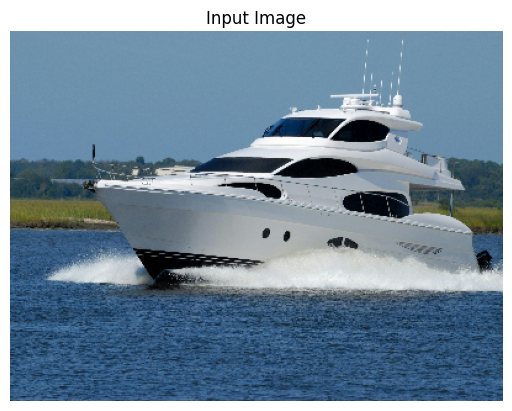

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

image = cv2.imread('images/img2.jpg') 
image = cv2.resize(image, (400, 300)) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title("Input Image")
plt.axis('off')
plt.show()


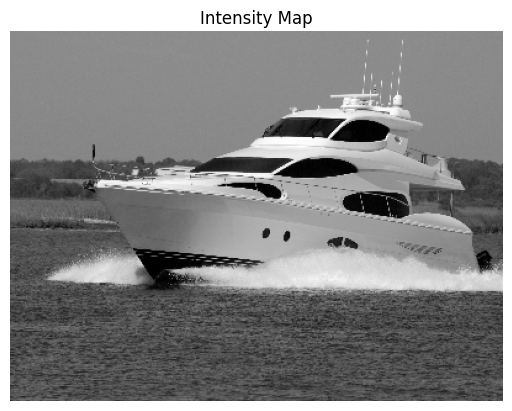

In [2]:
intensity = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(intensity, cmap='gray')
plt.title("Intensity Map")
plt.axis('off')
plt.show()


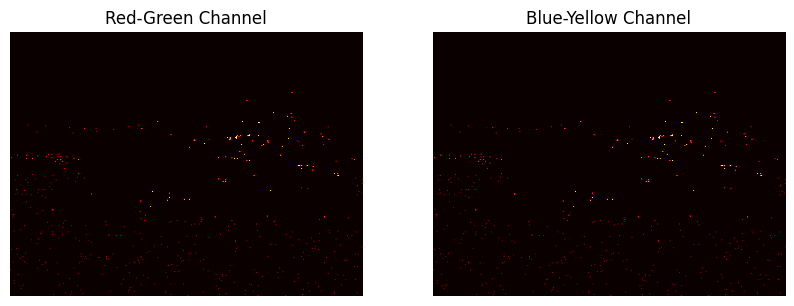

In [3]:
R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
R = R / (R + G + B + 1e-6)
G = G / (R + G + B + 1e-6)
B = B / (R + G + B + 1e-6)

RG = np.abs(R - G)
BY = np.abs(B - (R + G) / 2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(RG, cmap='hot')
plt.title("Red-Green Channel")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(BY, cmap='hot')
plt.title("Blue-Yellow Channel")
plt.axis('off')
plt.show()

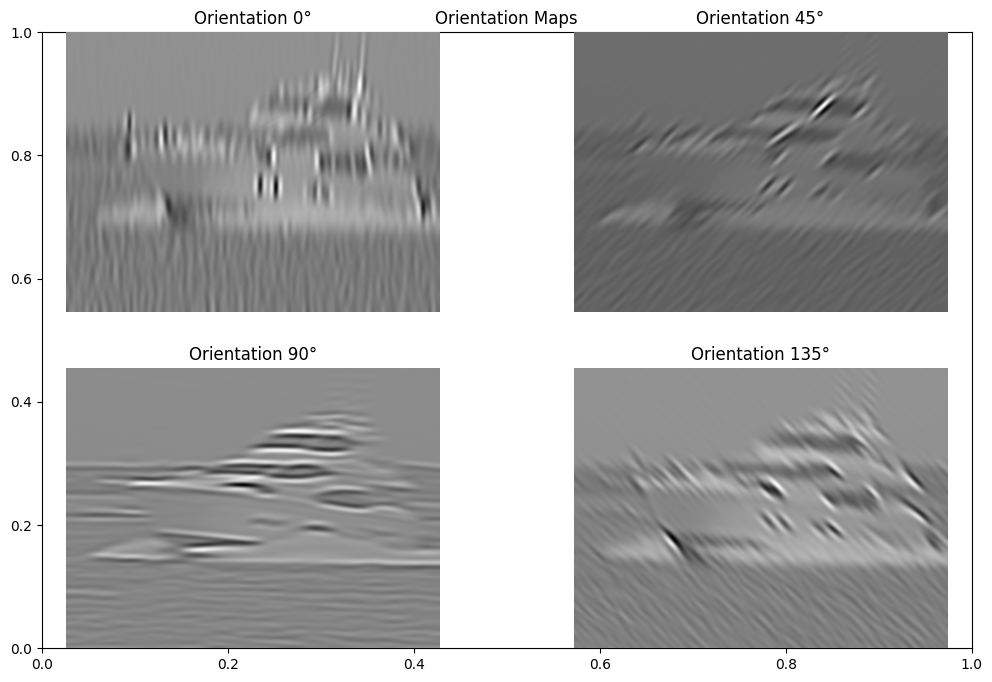

In [4]:
def gabor_filter(image, theta):
    kernel = cv2.getGaborKernel((31, 31), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
    return cv2.filter2D(image, cv2.CV_32F, kernel)

orientations = []
for angle in [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]:  
    filtered = gabor_filter(intensity, angle)
    orientations.append(filtered)


plt.figure(figsize=(12, 8))
plt.title("Orientation Maps")
for i, orientation in enumerate(orientations):
    plt.subplot(2, 2, i + 1)
    plt.imshow(orientation, cmap='gray')
    plt.title(f"Orientation {i * 45}°")
    plt.axis('off')
plt.show()

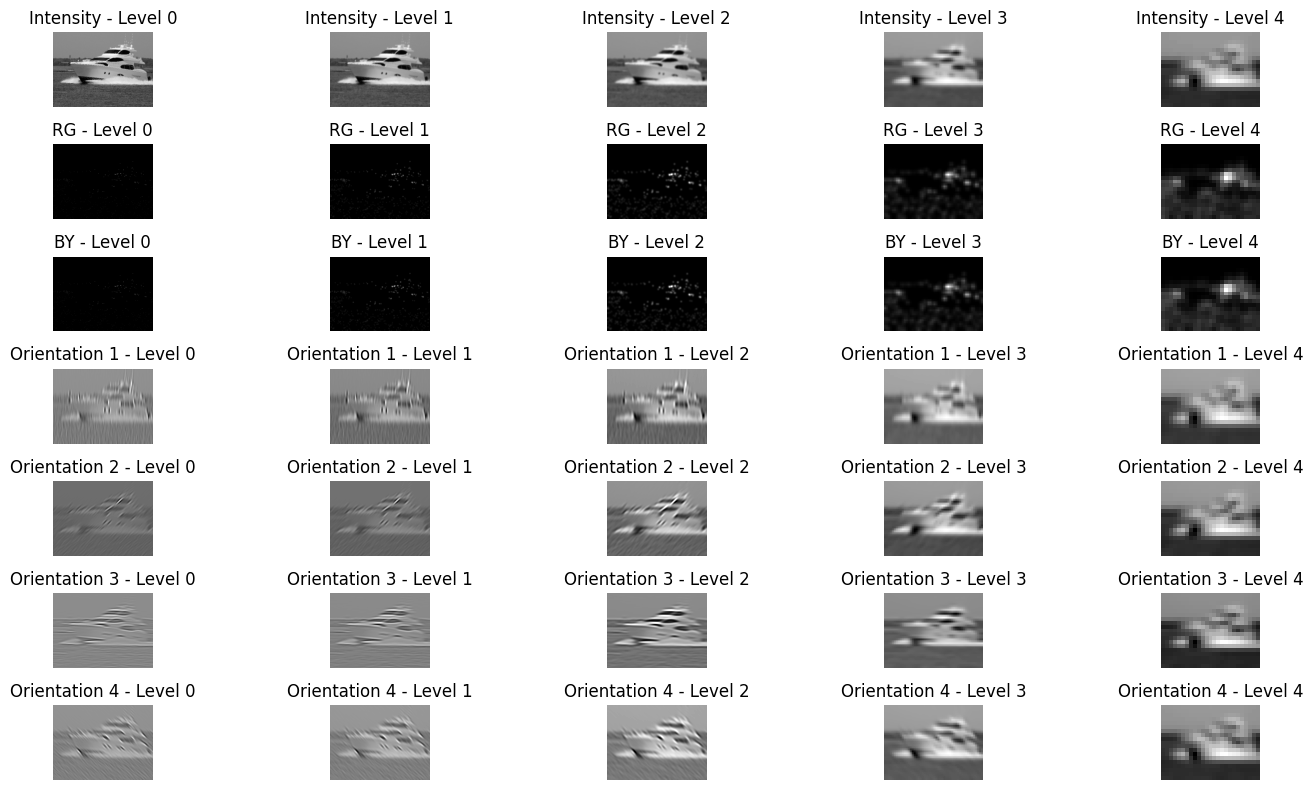

In [5]:
def build_gaussian_pyramid(image, levels=5):
    pyramid = [image]
    for i in range(1, levels):
        blurred = cv2.GaussianBlur(pyramid[-1], (5, 5), 1.0)
        downsampled = cv2.pyrDown(blurred)
        pyramid.append(downsampled)
    return pyramid

def visualize_pyramids(pyramids, pyramid_names, max_levels=5):
    plt.figure(figsize=(15, 8))
    for idx, (pyramid, name) in enumerate(zip(pyramids, pyramid_names)):
        num_levels = len(pyramid)
        for i in range(num_levels):
            plt.subplot(len(pyramids), max_levels, idx * max_levels + i + 1)
            plt.imshow(pyramid[i], cmap='gray')
            plt.title(f"{name} - Level {i}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()


intensity_pyramid = build_gaussian_pyramid(intensity)
rg_pyramid = build_gaussian_pyramid(RG)
by_pyramid = build_gaussian_pyramid(BY)
orientation_pyramids = [build_gaussian_pyramid(orientation) for orientation in orientations]


pyramids = [intensity_pyramid, rg_pyramid, by_pyramid] + orientation_pyramids
pyramid_names = ['Intensity', 'RG', 'BY'] + [f'Orientation {i+1}' for i in range(len(orientations))]

visualize_pyramids(pyramids, pyramid_names)


Number of pyramid levels: 5
Number of pyramid levels: 5
Number of pyramid levels: 5
Number of pyramid levels: 5
Number of pyramid levels: 5
Number of pyramid levels: 5
Number of pyramid levels: 5


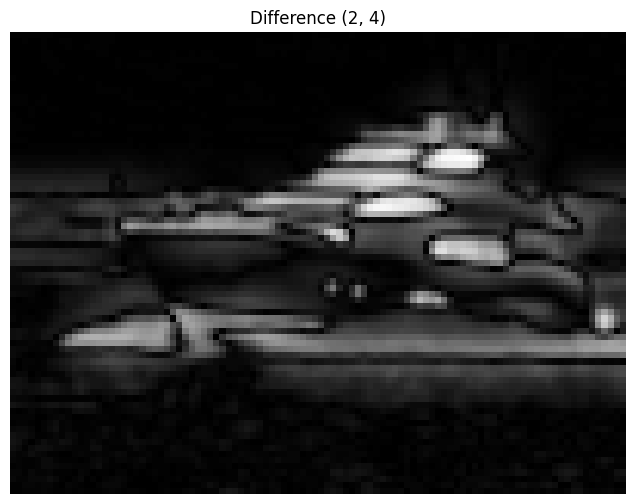

In [6]:
def compute_center_surround_differences(pyramid, level_pairs):
    num_levels = len(pyramid)
    print(f"Number of pyramid levels: {num_levels}")

    valid_level_pairs = [(center, surround) for center, surround in level_pairs if center < num_levels and surround < num_levels]
    if not valid_level_pairs:
        print("Not found")
        return []

    difference_maps = []
    for center, surround in valid_level_pairs:
        upsampled_surround = cv2.pyrUp(pyramid[surround])
        if upsampled_surround.shape != pyramid[center].shape:
            upsampled_surround = cv2.resize(upsampled_surround, (pyramid[center].shape[1], pyramid[center].shape[0]))
        difference = cv2.absdiff(pyramid[center], upsampled_surround)
        difference_maps.append(difference)
    return difference_maps

level_pairs = [(2, 4), (3, 5)]  

intensity_differences = compute_center_surround_differences(intensity_pyramid, level_pairs)
rg_differences = compute_center_surround_differences(rg_pyramid, level_pairs)
by_differences = compute_center_surround_differences(by_pyramid, level_pairs)
orientation_differences = [compute_center_surround_differences(pyramid, level_pairs) for pyramid in orientation_pyramids]

plt.figure(figsize=(12, 6))
for i, diff in enumerate(intensity_differences):
    plt.subplot(1, len(intensity_differences), i + 1)
    plt.imshow(diff, cmap='gray')
    plt.title(f"Difference {level_pairs[i]}")
    plt.axis('off')
plt.show()


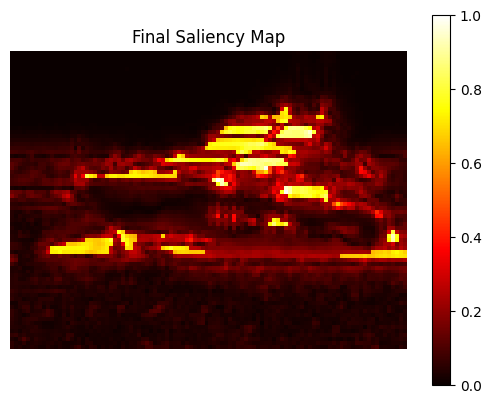

In [7]:
def combine_conspicuity_maps(conspicuity_maps_list, weights=None):
    if weights is not None:
        conspicuity_maps_list = [map * weight for map, weight in zip(conspicuity_maps_list, weights)]

    saliency_map = np.sum(conspicuity_maps_list, axis=0)
    saliency_map = cv2.normalize(saliency_map, None, 0, 1, cv2.NORM_MINMAX)

    return saliency_map

intensity_conspicuity = np.sum(intensity_differences, axis=0)
rg_conspicuity = np.sum(rg_differences, axis=0)
by_conspicuity = np.sum(by_differences, axis=0)

normalized_intensity = cv2.normalize(intensity_conspicuity, None, 0, 1, cv2.NORM_MINMAX)
normalized_rg = cv2.normalize(rg_conspicuity, None, 0, 1, cv2.NORM_MINMAX)
normalized_by = cv2.normalize(by_conspicuity, None, 0, 1, cv2.NORM_MINMAX)

orientation_conspicuity = []
for orientation_diff in orientation_differences:
    orientation_conspicuity.append(np.sum(orientation_diff, axis=0))
normalized_orientation = [cv2.normalize(o, None, 0, 1, cv2.NORM_MINMAX) for o in orientation_conspicuity]

all_conspicuities = [normalized_intensity, normalized_rg, normalized_by] + normalized_orientation
weights = [1.0, 0.7, 0.7] + [0.5] * len(normalized_orientation)  
final_saliency_map = combine_conspicuity_maps(all_conspicuities, weights)
plt.imshow(final_saliency_map, cmap='hot')
plt.colorbar()
plt.title("Final Saliency Map")
plt.axis('off')
plt.show()


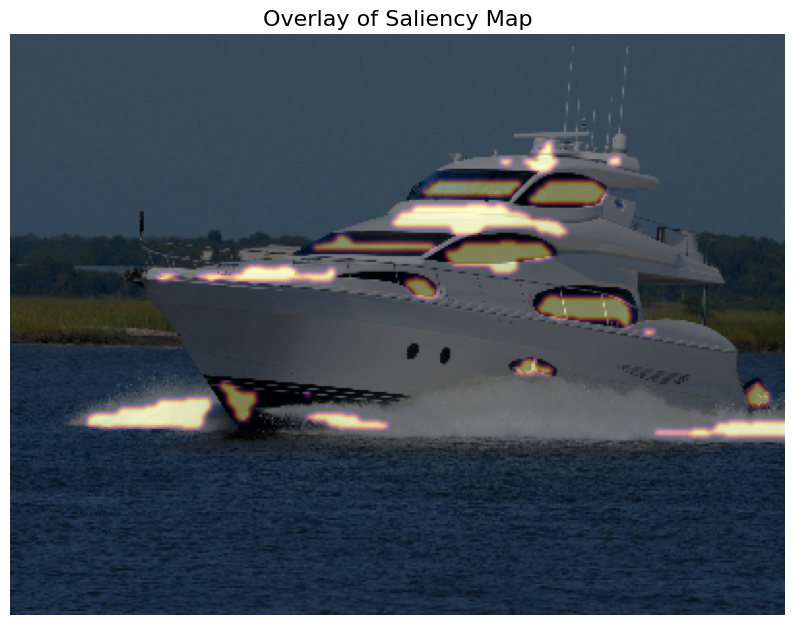

In [8]:
def overlay_saliency_map(original_image, saliency_map, threshold=0.5, colormap=cv2.COLORMAP_INFERNO, alpha=0.5):
    saliency_map_resized = cv2.resize(saliency_map, (original_image.shape[1], original_image.shape[0]))

    _, binary_mask = cv2.threshold(saliency_map_resized, threshold, 1, cv2.THRESH_BINARY)

    binary_mask = cv2.GaussianBlur(binary_mask, (5, 5), 0)

    heatmap = cv2.applyColorMap((binary_mask * 255).astype(np.uint8), colormap)

    if len(original_image.shape) == 3 and original_image.shape[2] == 3:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  

    overlay = cv2.addWeighted(original_image, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title("Overlay of Saliency Map", fontsize=16)
    plt.axis('off')
    plt.show()

overlay_saliency_map(image, final_saliency_map)


In [9]:
def interactive_saliency(saliency_map, image):
    saliency_map_normalized = cv2.normalize(saliency_map, None, 0, 1, cv2.NORM_MINMAX)

    image_resized = cv2.resize(image, (saliency_map.shape[1], saliency_map.shape[0]))
    if len(image.shape) == 3:  
        image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

    image_resized_normalized = image_resized / 255.0

    x = np.arange(saliency_map.shape[1])
    y = np.arange(saliency_map.shape[0])
    x, y = np.meshgrid(x, y)

    fig = go.Figure()

    fig.add_trace(
        go.Surface(
            z=np.zeros_like(saliency_map_normalized),  
            x=x,
            y=y,
            surfacecolor=image_resized_normalized[..., 0], 
            colorscale='gray',  
            cmin=0,  
            cmax=1,  
            showscale=False,
            name="Background Image"
        )
    )

    fig.add_trace(
        go.Surface(
            z=saliency_map_normalized,  
            x=x,
            y=y,
            surfacecolor=saliency_map_normalized,
            colorscale='Viridis',  
            opacity=0.4,  
            showscale=True,
            name="Saliency Map"
        )
    )

    fig.update_layout(
        scene=dict(
            xaxis=dict(title="X-axis", visible=True),
            yaxis=dict(title="Y-axis", visible=True),
            zaxis=dict(title="Saliency Value", visible=True),
            aspectratio=dict(x=1, y=1, z=0.5),  
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
        ),
        title="Interactive Saliency Map",
        margin=dict(l=0, r=0, t=50, b=0)  
    )

    fig.show()

interactive_saliency(final_saliency_map, image)


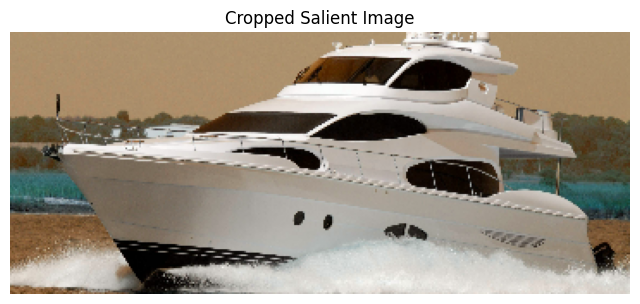

In [10]:
def crop_saliency(image, saliency_map, threshold=0.5, min_area=100):
    saliency_map_resized = cv2.resize(saliency_map, (image.shape[1], image.shape[0]))
    saliency_map_normalized = cv2.normalize(saliency_map_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, binary_map = cv2.threshold(saliency_map_normalized, int(threshold * 255), 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print("No salient regions found.")
        return image, [] 

    x_min, y_min = float("inf"), float("inf")
    x_max, y_max = float("-inf"), float("-inf")

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h >= min_area:  
            x_min = min(x_min, x)
            y_min = min(y_min, y)
            x_max = max(x_max, x + w)
            y_max = max(y_max, y + h)

    x_min = max(x_min, 0)
    y_min = max(y_min, 0)
    x_max = min(x_max, image.shape[1])
    y_max = min(y_max, image.shape[0])

    cropped_image = image[y_min:y_max, x_min:x_max]

    return cropped_image

cropped_image = crop_saliency(image, final_saliency_map, threshold=0.5, min_area=100)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title("Cropped Salient Image")
plt.axis('off')
plt.show()


In [11]:
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision import transforms
from PIL import Image
import json 

def load_pretrained_classifier():
    model = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
    model.eval()  
    class_labels_file = "class_labels.json"

    with open(class_labels_file, 'r') as f:
        class_labels = json.load(f)
    return model, class_labels

def preprocess_image(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])
    return transform(image).unsqueeze(0)  

def classify_image(model, image_tensor, class_labels):
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        top_prob, top_class_idx = probabilities.max(0)
        top_class = class_labels[top_class_idx.item()]

    return top_class, top_prob.item()

def visualize_classification(image, class_label, confidence):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Class: {class_label}\nConfidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()

model, class_labels = load_pretrained_classifier()


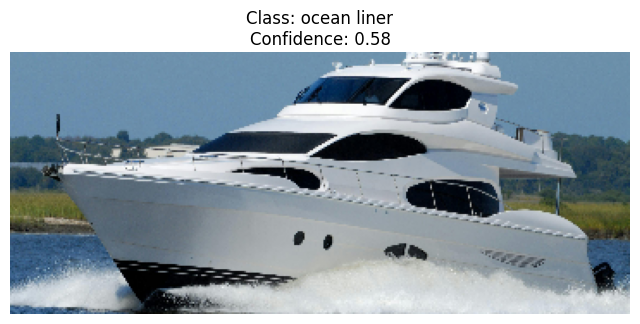

In [12]:
cropped_tensor = preprocess_image(cropped_image)

predicted_class, confidence = classify_image(model, cropped_tensor, class_labels)

visualize_classification(cropped_image, predicted_class, confidence)